In [1]:
# Generic
from pathlib import Path
import typing
import json
from pathlib import Path
import typing
import html
import copy

# Transformers
import circuitsvis # keep this import since we need to disable circuitsvis in CI
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch

# Our Code
from maze_transformer.utils.notebook_utils import configure_notebook
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer
from maze_transformer.dataset.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.utils.utils import pprint_summary
from maze_transformer.evaluation.plot_attention import ProcessedMazeAttention



In [2]:
# Setup
DEVICE = configure_notebook(seed=42, dark_mode=True)
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# We won't be training any models
torch.set_grad_enabled(False)

MODEL_PATH: Path = PATH_EXAMPLES / "multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj"
print(f"will try to get model from {MODEL_PATH.as_posix()}")

# get the default model from examples
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
print(f"loaded model: {MODEL.zanj_model_config.name} with {MODEL.num_params()} parameters")

# generate a smaller test dataset
DATASET_TEST_CFG: MazeDatasetConfig = copy.deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_TEST_CFG.n_mazes = 100
DATASET_TEST: MazeDataset = MazeDataset.from_config(
    DATASET_TEST_CFG,
    local_base_path=PATH_DATA,
    verbose=True,
)
print(f"got test dataset: {DATASET_TEST.cfg.name} with {len(DATASET_TEST)} mazes")

# print a summary of the model config
pprint_summary(MODEL.zanj_model_config.model_cfg.summary())

will try to get model from ../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj
loaded model: multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1 with 70319 parameters
loading dataset from ../data/demo-g6-n100-a_dfs-h88923.zanj
Got dataset demo with 100 items. output.cfg.to_fname() = 'demo-g6-n100-a_dfs-h88923'
got test dataset: demo with 100 mazes
{
  "name": "tiny-v1",
  "act_fn": "gelu",
  "d_model": 32,
  "d_head": 16,
  "n_layers": 4,
  "weight_processing": {
    "are_layernorms_folded": false,
    "are_weights_processed": true
  },
  "n_heads": 2
}


{
  "tokens": "<ADJLIST_START> (1,0) <--> (2,0) ; (3,1) <--> (3,2) ; (1,0) <--> (1,1) ; (0,0) <--> (1,0) ; (4,3) <--> (4,2) ; (4,0) <--> (4,1) ; (3,3) <--> (4,3) ; (5,5) <--> (5,4) ; (5,0) <--> (4,0) ; (2,3) <--> (2,4) ; (0,1) <--> (0,2) ; (5,1) <--> (5,2) ; (3,1) <--> (2,1) ; (3,2) <--> (3,3) ; (1,2) <--> (2,2) ; (2,4) <--> (2,5) ; (5,2) <--> (5,3) ; (2,2) <--> (2,1) ; (5,4) <--> (5,3) ; (0,4) <--> (0,3) ; (1,5) <--> (0,5) ; (0,2) <--> (0,3) ; (4,5) <--> (5,5) ; (1,4) <--> (0,4) ; (4,3) <--> (4,4) ; (2,5) <--> (1,5) ; (4,5) <--> (3,5) ; (1,3) <--> (2,3) ; (5,1) <--> (5,0) ; (0,0) <--> (0,1) ; (4,2) <--> (4,1) ; (1,4) <--> (1,5) ; (1,2) <--> (0,2) ; (3,5) <--> (3,4) ; (3,0) <--> (2,0) ; <ADJLIST_END> <ORIGIN_START> (2,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (2,5) (1,5) (1,4) (0,4) (0,3) (0,2) (1,2) (2,2) (2,1) <PATH_END>",
  "tokens_context": "<ADJLIST_START> (1,0) <--> (2,0) ; (3,1) <--> (3,2) ; (1,0) <--> (1,1) ; (0,0) <--> (1,0) ; (4,3) <--> (4,2) ; (4,0) <-->

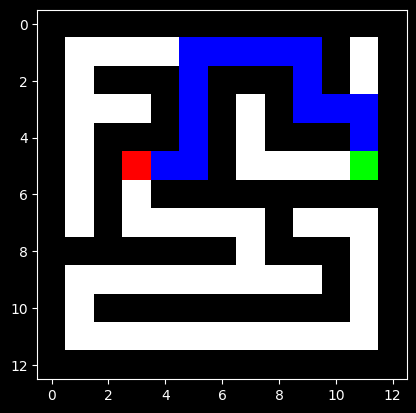

In [3]:
# process the attention data for a single maze
ATTENTION_DATA: ProcessedMazeAttention = ProcessedMazeAttention.from_model_and_dataset(
	model=MODEL, dataset=DATASET_TEST, n_mazes=1,
)[0]

# print the summary of the attention data
pprint_summary(ATTENTION_DATA.summary())

# show the actual maze we are looking at
plt.imshow(ATTENTION_DATA.input_maze.as_pixels())

In [4]:
# plot a highlight of which tokens are being attended to in the sequence
ATTENTION_DATA.plot_colored_tokens_multi()

['<ADJLIST_START>', '(1,0)', '<-->', '(2,0)', ';', '(3,1)', '<-->', '(3,2)', ';', '(1,0)', '<-->', '(1,1)', ';', '(0,0)', '<-->', '(1,0)', ';', '(4,3)', '<-->', '(4,2)', ';', '(4,0)', '<-->', '(4,1)', ';', '(3,3)', '<-->', '(4,3)', ';', '(5,5)', '<-->', '(5,4)', ';', '(5,0)', '<-->', '(4,0)', ';', '(2,3)', '<-->', '(2,4)', ';', '(0,1)', '<-->', '(0,2)', ';', '(5,1)', '<-->', '(5,2)', ';', '(3,1)', '<-->', '(2,1)', ';', '(3,2)', '<-->', '(3,3)', ';', '(1,2)', '<-->', '(2,2)', ';', '(2,4)', '<-->', '(2,5)', ';', '(5,2)', '<-->', '(5,3)', ';', '(2,2)', '<-->', '(2,1)', ';', '(5,4)', '<-->', '(5,3)', ';', '(0,4)', '<-->', '(0,3)', ';', '(1,5)', '<-->', '(0,5)', ';', '(0,2)', '<-->', '(0,3)', ';', '(4,5)', '<-->', '(5,5)', ';', '(1,4)', '<-->', '(0,4)', ';', '(4,3)', '<-->', '(4,4)', ';', '(2,5)', '<-->', '(1,5)', ';', '(4,5)', '<-->', '(3,5)', ';', '(1,3)', '<-->', '(2,3)', ';', '(5,1)', '<-->', '(5,0)', ';', '(0,0)', '<-->', '(0,1)', ';', '(4,2)', '<-->', '(4,1)', ';', '(1,4)', '<-->', '(

(<Figure size 2000x2000 with 16 Axes>,
 array([[<Axes: title={'center': 'Layer 0 Head 0'}, xlabel='col', ylabel='row'>,
         <Axes: title={'center': 'Layer 0 Head 1'}, xlabel='col', ylabel='row'>],
        [<Axes: title={'center': 'Layer 1 Head 0'}, xlabel='col', ylabel='row'>,
         <Axes: title={'center': 'Layer 1 Head 1'}, xlabel='col', ylabel='row'>],
        [<Axes: title={'center': 'Layer 2 Head 0'}, xlabel='col', ylabel='row'>,
         <Axes: title={'center': 'Layer 2 Head 1'}, xlabel='col', ylabel='row'>],
        [<Axes: title={'center': 'Layer 3 Head 0'}, xlabel='col', ylabel='row'>,
         <Axes: title={'center': 'Layer 3 Head 1'}, xlabel='col', ylabel='row'>]],
       dtype=object))

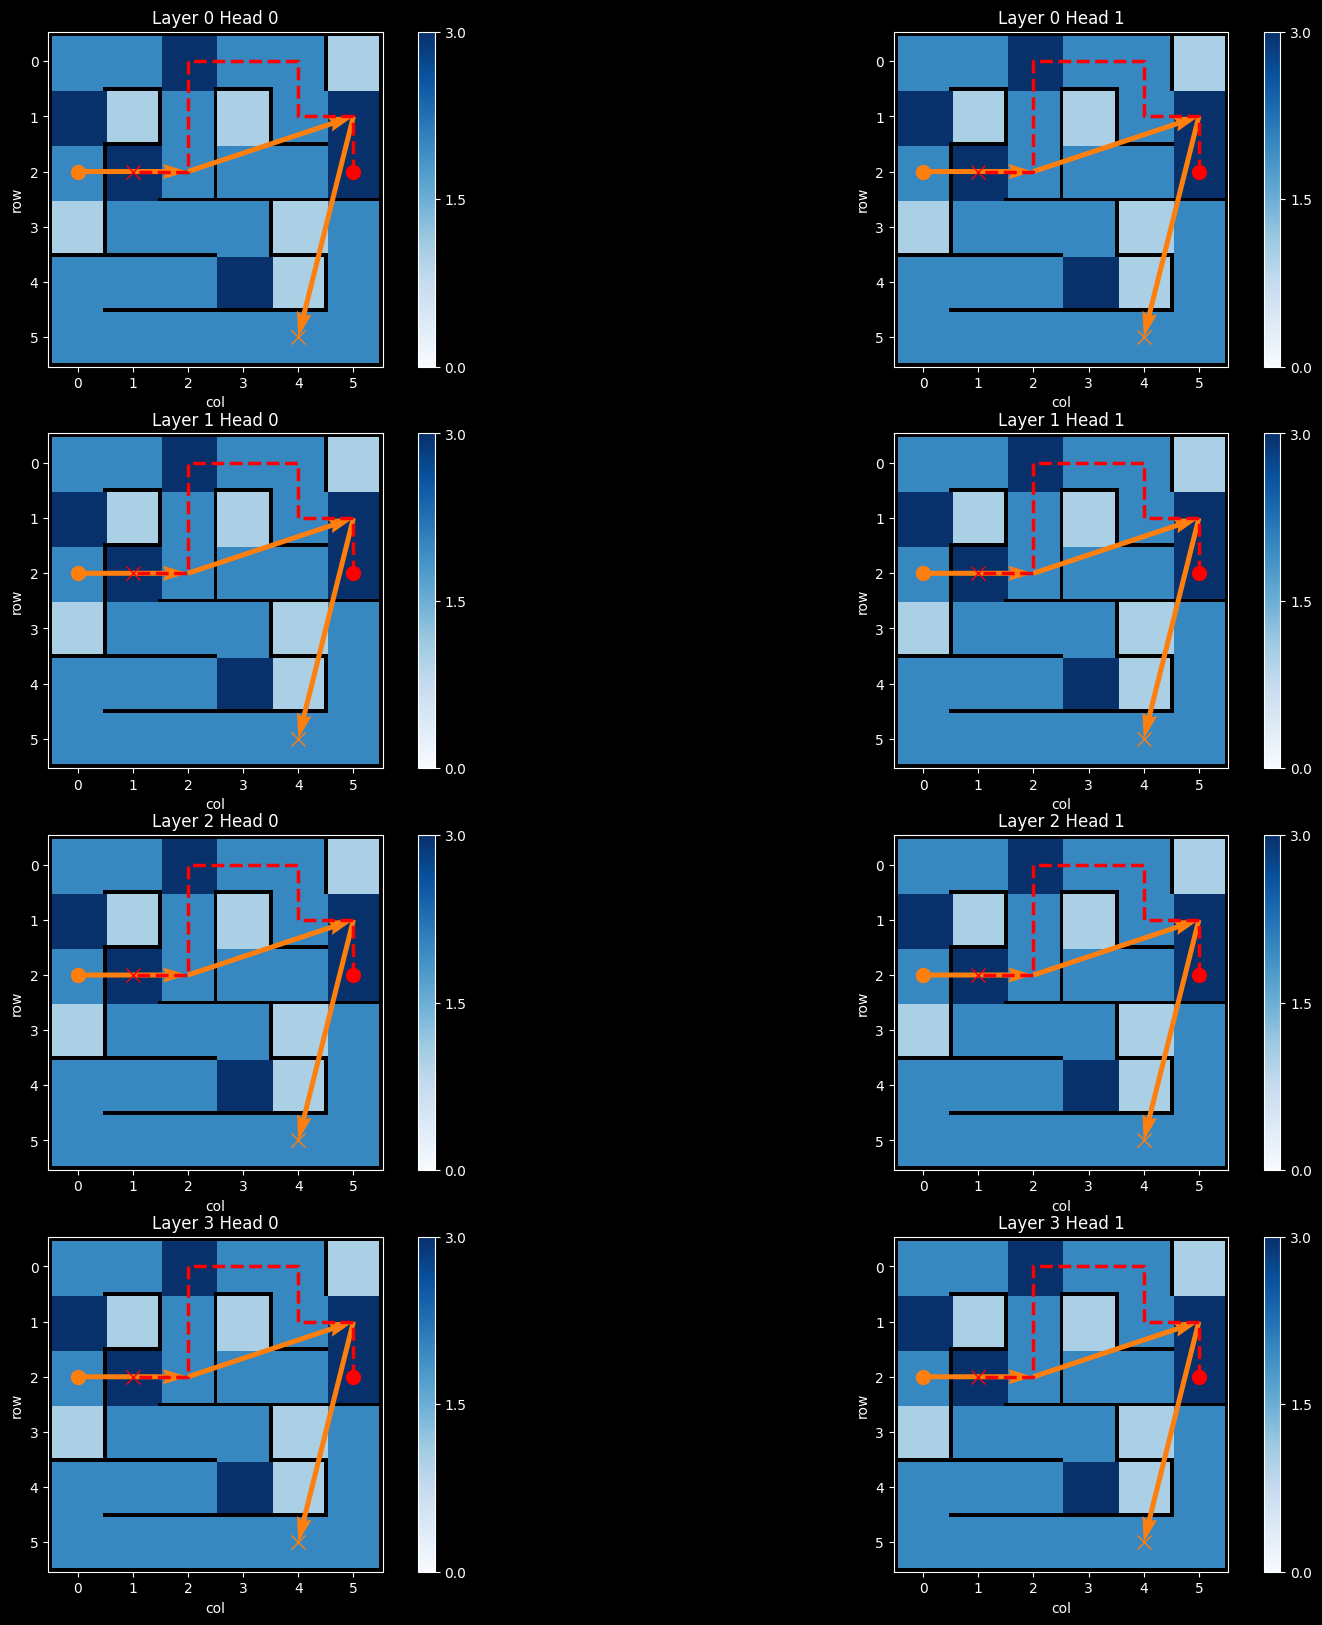

In [5]:
ATTENTION_DATA.plot_attentions_on_maze(
    predict_path_len=10,
    model=MODEL,
    dataset_cfg=DATASET_TEST.cfg,
)

In [1]:
# this function plots the attention head values for all the token pairs, for each head on each layer
# ATTENTION_DATA.plot_attentions()